<a href="https://colab.research.google.com/github/stefarine/DMML2022_ROLEX/blob/main/DMML_PROJECT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Data Importation and statistics

##Importation 

In [2]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from sklearn import metrics
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import KFold, GridSearchCV
from sklearn.neighbors import KNeighborsRegressor

random_state=0

df = pd.read_csv('training_data.csv')
df_pred = pd.read_csv('unlabelled_test_data.csv')

In [3]:
X = df['sentence']
y = df['difficulty']
X_pred = df_pred['sentence']

##Descriptive statistics and baseline

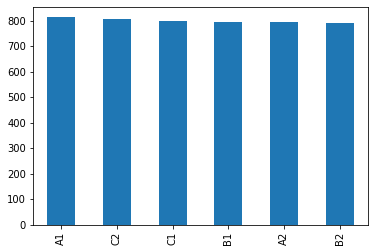

In [4]:
plot = y.value_counts().plot.bar()

In [5]:
y.describe()

count     4800
unique       6
top         A1
freq       813
Name: difficulty, dtype: object

In [6]:
base_rate = (df['difficulty'].value_counts().max()/df['difficulty'].shape[0]).round(4)
print('Base rate :')
print(base_rate)

Base rate :
0.1694


#Models

In [7]:
#Define vectorizer and split the set
tfidf = TfidfVectorizer(ngram_range=(1, 1))
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [8]:
# Function to evaluate the model
def evaluate(true, pred):
    precision = precision_score(true, pred,average='macro')
    recall = recall_score(true, pred,average='macro')
    f1 = f1_score(true, pred,average='macro')
    print(f"CONFUSION MATRIX:\n{confusion_matrix(true, pred)}")
    print(f"ACCURACY SCORE:\n{accuracy_score(true, pred):.4f}")
    print(f"CLASSIFICATION REPORT:\n\tPrecision: {precision:.4f}\n\tRecall: {recall:.4f}\n\tF1_Score: {f1:.4f}")

In [13]:
#Function to create a pipeline with TFIDF and a classifier
def pipeWithTFIDF(myClassifier):
  pipe = Pipeline([('vectorizer', tfidf),
                 ('classifier', myClassifier)])
  return pipe

In [14]:
#Method to fit a model, make pradiction with it and get evaluation stuff
def fitPredictAndEvaluateModel(pipe):
  # Fit model on training set
  pipe.fit(X_train, y_train)

  # Predictions
  y_pred= pipe.predict(X_test)

  # Evaluation
  evaluate(y_test, y_pred)

  return y_pred

In [15]:
#Method to make a gride search and print the results
def getResultsGridSearch(myGs):
  #Pipeline preparation
  pipe = pipeWithTFIDF(myGs)

  #fit
  pipe.fit(X_train, y_train)

  #Print results
  print('Best Score : ')
  print(myGs.best_score_)
  print('Best Params : ')
  print(myGs.best_params_)

## Logistic Regression with TFidf vectoriser (no data cleaning)

In [16]:
#Define classifier and pipeline creation
LR = LogisticRegression(solver='lbfgs', random_state=0)
pipe_LR = pipeWithTFIDF(LR)

# fit, predict and evaluate
y_pred_LR = fitPredictAndEvaluateModel(pipe_LR)


CONFUSION MATRIX:
[[93 31 21 10  4  2]
 [54 60 30  6  6  8]
 [12 38 64 17  9 20]
 [ 6  6 15 66 27 24]
 [ 4  4 10 37 73 45]
 [ 7  8  8 19 24 92]]
ACCURACY SCORE:
0.4667
CLASSIFICATION REPORT:
	Precision: 0.4645
	Recall: 0.4677
	F1_Score: 0.4640


## KNN & hyperparameter optimization (no data cleaning)

In [17]:
# Import KNeighborsClassifier
from sklearn.neighbors import KNeighborsClassifier

###Knn Basic

In [18]:
# Define classifier and pipeline creation
knn = KNeighborsClassifier()
pipe_knn = pipeWithTFIDF(knn)

# fit, predict and evaluate
y_pred_knn = fitPredictAndEvaluateModel(pipe_knn)

CONFUSION MATRIX:
[[121  28   8   1   1   2]
 [ 98  51  12   1   1   1]
 [ 81  39  33   3   1   3]
 [ 49  30  19  29   3  14]
 [ 48  36  29  15  29  16]
 [ 37  29  17  23   9  43]]
ACCURACY SCORE:
0.3187
CLASSIFICATION REPORT:
	Precision: 0.4007
	Recall: 0.3183
	F1_Score: 0.3022


###Knn with hyperparameter optimization 

In [19]:
#Preparation of the GridSearch
seed = 0
grid_params = { 'n_neighbors' : [5,7,9,11,13,15],
               'weights' : ['uniform','distance'],
               'metric' : ['minkowski','euclidean','manhattan']}
gs = GridSearchCV(KNeighborsClassifier(), grid_params, verbose = 1, cv=3, n_jobs = -1)

#GridSearch and Print Results
getResultsGridSearch(gs)

Fitting 3 folds for each of 36 candidates, totalling 108 fits
Best Score : 
0.3466145833333334
Best Params : 
{'metric': 'minkowski', 'n_neighbors': 11, 'weights': 'distance'}


In [40]:
# Define classifier and pipeline creation 
## This time we put the parameters we got in previous step
knn_GS = KNeighborsClassifier(n_neighbors = 11, weights = 'distance',metric = 'minkowski')
pipe_knn = pipeWithTFIDF(knn)

# fit, predict and evaluate
y_pred_knn_GS = fitPredictAndEvaluateModel(pipe_knn)

CONFUSION MATRIX:
[[121  28   8   1   1   2]
 [ 98  51  12   1   1   1]
 [ 81  39  33   3   1   3]
 [ 49  30  19  29   3  14]
 [ 48  36  29  15  29  16]
 [ 37  29  17  23   9  43]]
ACCURACY SCORE:
0.3187
CLASSIFICATION REPORT:
	Precision: 0.4007
	Recall: 0.3183
	F1_Score: 0.3022


##Decision Tree & Hyperparameter optimization (no data cleaning))

In [21]:
# Import Decision Tree Classifier
from sklearn.tree import DecisionTreeClassifier

### Decision tree Basic

In [46]:
# Define classifier and pipeline creation
dt = DecisionTreeClassifier(random_state=0)
pipe_dt = pipeWithTFIDF(dt)

# fit, predict and evaluate
y_pred_dt = fitPredictAndEvaluateModel(pipe_dt)

CONFUSION MATRIX:
[[78 38 25 11  2  7]
 [49 54 33 18  3  7]
 [24 41 37 25 18 15]
 [10 20 30 38 24 22]
 [ 8 19 31 39 39 37]
 [15 13 28 33 30 39]]
ACCURACY SCORE:
0.2969
CLASSIFICATION REPORT:
	Precision: 0.2986
	Recall: 0.2969
	F1_Score: 0.2945


###Decision Tree with hyperparameter optimization

In [50]:
#Preparation of the GridSearch
seed = 0
grid_params = {'max_depth' : range(1,60)}
gs = GridSearchCV(DecisionTreeClassifier(), grid_params, verbose = 1, cv=3, n_jobs = -1)

#GridSearch and Print Results
getResultsGridSearch(gs)


Fitting 3 folds for each of 59 candidates, totalling 177 fits
Best Score : 
0.3260416666666666
Best Params : 
{'max_depth': 47}


In [48]:
# Define classifier and pipeline creation
dt = DecisionTreeClassifier(max_depth=43, random_state=0)
pipe_dt_GS = pipeWithTFIDF(dt)

# fit, predict and evaluate
y_pred_dt_GS = fitPredictAndEvaluateModel(pipe_dt_GS)

CONFUSION MATRIX:
[[84 34 29  7  1  6]
 [48 53 36 15  4  8]
 [34 39 38 18 17 14]
 [ 9 23 27 44 19 22]
 [14 19 27 47 35 31]
 [16 12 27 37 32 34]]
ACCURACY SCORE:
0.3000
CLASSIFICATION REPORT:
	Precision: 0.2987
	Recall: 0.3009
	F1_Score: 0.2947


## Random Forest (no data cleaning)

In [51]:
from sklearn.ensemble import RandomForestClassifier

In [52]:
# Define classifier and pipeline creation
rf = RandomForestClassifier(random_state=0)
pipe_rf = pipeWithTFIDF(rf)

# fit, predict and evaluate
y_pred_rf = fitPredictAndEvaluateModel(pipe_rf)

CONFUSION MATRIX:
[[125  20   7   7   2   0]
 [ 83  51  21   7   2   0]
 [ 39  39  47  20   6   9]
 [ 17  11  13  68  23  12]
 [ 16  16  23  46  46  26]
 [ 19  13  10  33  23  60]]
ACCURACY SCORE:
0.4135
CLASSIFICATION REPORT:
	Precision: 0.4223
	Recall: 0.4165
	F1_Score: 0.4014
